### Autoregressive Models

$\mathbf{X}$ is a $n \times p$ Hankel matrix of lagged time series values. The number of lagged, past values is the order of the model, $p$, and $\mathbf{y}$ is a vector of $p+1$ values, e.g. an 20th order model uses twenty values to predict the next value of the signal in a sliding window fashion. Autoregression (AR) models describe this linear system, where a vector of weights, $\mathbf{b}$, is learned to best predict $\mathbf{y}$.


$$
\mathbf{X} =
    \left[ {\begin{array}{ccccc}
    x_{0} & x_{1} & x_{2} & \cdots & x_{p}\\
    x_{1} & x_{2} & x_{3} & \cdots & x_{p+1}\\
    x_{2} & x_{3} & x_{4} & \cdots & x_{p+2}\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    x_{n-p-1} & x_{n-p} & x_{n-p+1} & \cdots & x_{n-1}\\
    \end{array} } \right] \\
\mathbf{y}^{\top} = 
    \left[ {\begin{array}{c}
    x_{p+1} \\
    x_{p+2} \\
    x_{p+3} \\ 
    \cdots \\
    x_{n} \\ 
    \end{array} } \right] \\
$$

Like other linear systems, the solution to this problem involves inverting $\mathbf{X}$, which may be computationally costly. 

$$
\begin{align}
\mathbf{X} \mathbf{b} &= \mathbf{y} \\
\mathbf{b} &= \mathbf{X}^{-1}\mathbf{y} \\
\end{align}
$$

However, inversion of $\mathbf{X}$ may be computational costly and a single solution may not exist. The standard solution to AR models is Burg's method (1967), which struggles under large orders and particular conditions [oscillations, sometimes].

### Singular Value Decomposition (SVD)

SVD decomposes a matrix into left and right singular vectors ($\mathbf{U}$ and $\mathbf{V}$, respectively) and singular values, $\mathbf{S}$.

$$
\mathbf{X} = \mathbf{U} \mathbf{S} \mathbf{V}^{\top}
$$

SVD can be used to approximate $\mathbf{X}^{-1}$. The use of SVD to solve a linear system is referred to as the pseudo inverse method. Since $\mathbf{S}$ is a diagonal matrix, its inversion is computationally less expensive then inverting $\mathbf{X}$.

$$
\mathbf{S}^{-1} = \begin{equation*}
\begin{bmatrix}
    \frac{1}{\sigma_1} & 0 & \ldots & 0 \\
    0 & \frac{1}{\sigma_2} & \ldots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \ldots & \frac{1}{\sigma_p} \\
\end{bmatrix}
\end{equation*}
$$


The inversion of the SVD of X is:
$$
\begin{align}
\mathbf{X} &= \mathbf{V}\mathbf{S}^{-1}\mathbf{U}^{\top}
\end{align}
$$

And the autoregressive linear equation becomes:
$$
\begin{align}
\mathbf{b} &= \mathbf{V}\mathbf{S}^{-1}\mathbf{U}^{\top}\mathbf{y}
\end{align}
$$


Standard SVD is solved in $O(n \times p^2)$ time. Large orders, $p$, drastically increases the compute time. Randomized SVD may be solved in $O(n \times p \times log(p))$. If $\mathbf{X}$ is rank deficient, a smaller order is sufficient decreasing computation time. This may be determined once singular value $\sigma$ becomes succificiently small (e.g. $\sigma \lt 1.$).

Aperiodic or stochastic signals produce a full rank $\mathbf{X}$. However, oscillations or periodic signals produce a rank deficient matrix.

### Periodic: Oscillations

Oscillations produce identical columns in $\mathbf{X}$, indicated by vertical black lines Fig. 1. Fig2. 

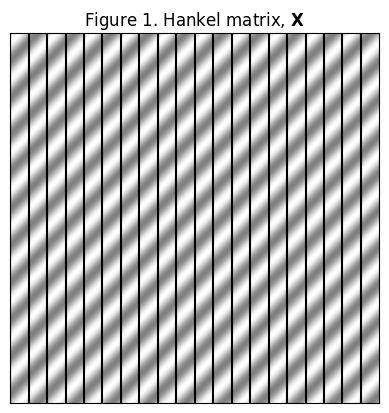

In [785]:
p = 1000

sig = np.sin(np.linspace(0, (2*np.pi*20), 2001)).round(2)

X = np.lib.stride_tricks.as_strided(sig,
    shape=(len(sig)-p+1, p),
    strides=((sig.itemsize, sig.itemsize))
)[:-1]

y = sig[p:]


plt.imshow(X, cmap='gray', alpha=.5)

for i in np.where(X[0] == 0.)[0]:
    plt.axvline(i, color='k')

plt.title(r"Figure 1. Hankel matrix, $\mathbf{X}$")
plt.xticks([])
plt.yticks([]);

In [872]:
p = 1000

sig = np.sin(np.linspace(0, (2*np.pi*20), 2001)).round(2)

np.random.seed(0)
sig = sig + np.random.rand(len(sig)) / 100

X = np.lib.stride_tricks.as_strided(sig,
    shape=(len(sig)-p+1, p),
    strides=((sig.itemsize, sig.itemsize))
)[:-1]

y = sig[p:]

# Tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# SVD
U, S, V = torch.svd_lowrank(X_tensor, p, 1)

# Burg
ar_coeffs_burg, _ = burg(sig, p)

# Zero small singular values
mask = S < 1.
S_diag = torch.diag(1/S)
S_diag[mask, mask] = 0.

# AR
ar_coeffs_svd = V @ S_diag @ U.T @ y_tensor
ar_coeffs_svd  = ar_coeffs_svd.numpy()

In [873]:
print("MSE SVD : ", (((X@ar_coeffs_svd)-y)**2).mean())
print("MSE Burg: ", (((X@ar_coeffs_burg[::-1])-y)**2).mean())

MSE SVD :  1.608347681025353e-05
MSE Burg:  3.831716020611763e-05


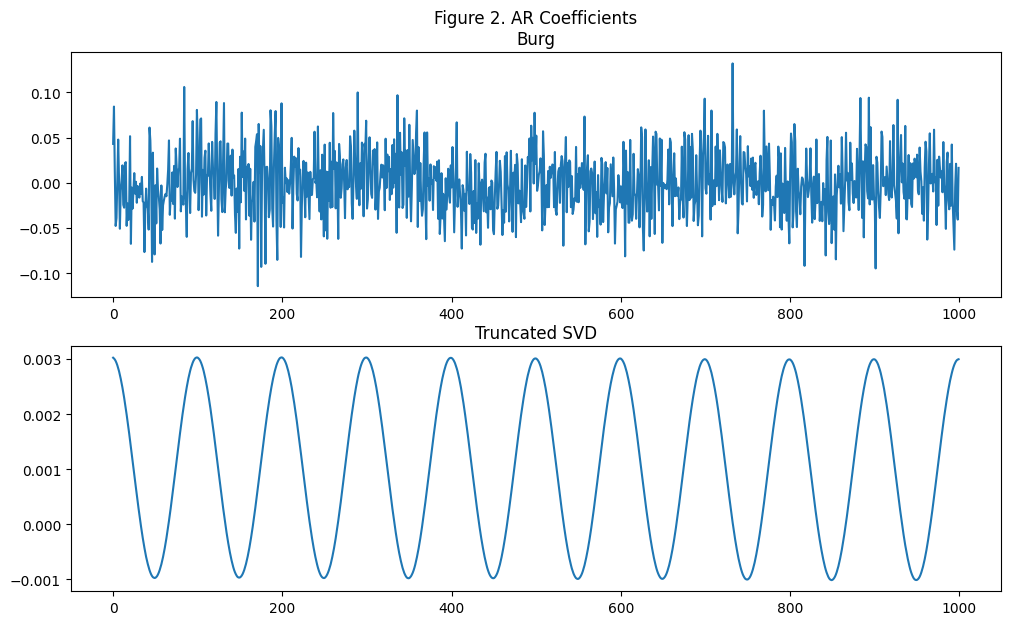

In [874]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 7))

axes[0].plot(ar_coeffs_burg)
axes[1].plot(ar_coeffs_svd[::-1])

axes[0].set_title("Figure 2. AR Coefficients\nBurg")
axes[1].set_title("Truncated SVD");

### Aperiodic: Timescales

For aperiodic, non-oscillatory, or stochastic processes, the order of the AR model may be small since many simulation methods are AR(1) processes. In this case, truncated SVD converges to a similar solution as Burg's method.

In [908]:
from timescales.sim import sim_branching
from timescales.conversions import ar_to_psd
import torch

# Simulate
n_seconds = 2
fs = 1000
tau = 0.01
sig = sim_branching(n_seconds, fs, tau, 1000, mean=0, variance=1)

# AR order
p = 10
y = sig[p:]

# Lag signal
X = np.lib.stride_tricks.as_strided(sig,
    shape=(len(sig)-p+1, p),
    strides=((sig.itemsize, sig.itemsize))
)[:-1]

y = sig[p:]

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

In [909]:
%%timeit -n 1 -r 1
# Standard SVD, slow
U, S, Vt = svd(X, full_matrices=False,
               overwrite_a=False, check_finite=False)
ar_coeffs = Vt.T @ np.diag(1/S) @ U.T @ y

11.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [910]:
%%timeit -n 1 -r 1
# Truncated SVD, faster
U, S, V = torch.svd_lowrank(X_tensor, p, 1)
ar_coeffs_svd = V @ np.diag(1/S) @ U.T @ y_tensor

1.89 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [911]:
%%timeit -n 1 -r 1
# Burg, fast
ar_coeffs_burg, _ = burg(sig, p)

1.69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [912]:
U, S, V = torch.svd_lowrank(X_tensor, p, 1)

ar_coeffs_svd = V @ np.diag(1/S) @ U.T @ y_tensor

# Zero low singular values
mask = S < 1.
S_diag = torch.diag(1/S)
S_diag[mask, mask] = 0.

# Solve linear equation
ar_coeffs_svd = V @ S_diag @ U.T @ y_tensor

# To numpy array
ar_coeffs_svd = ar_coeffs_svd.numpy()

# Burg
ar_coeffs_burg, _ = burg(sig, p)

In [913]:
print("MSE SVD : ", (((X@ar_coeffs_svd)-y)**2).mean())
print("MSE Burg: ", (((X@ar_coeffs_burg[::-1])-y)**2).mean())

MSE SVD :  0.16454230929864458
MSE Burg:  0.16454387950678476


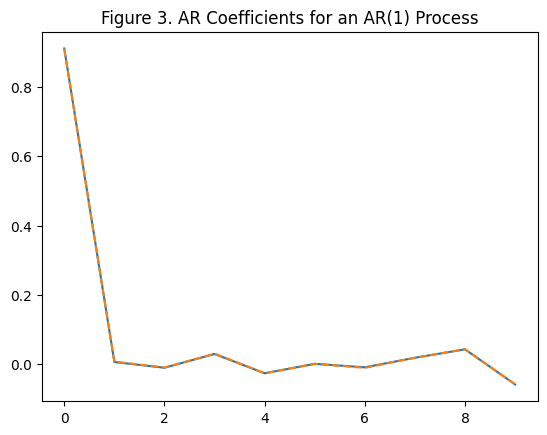

In [915]:
# Burg
plt.plot(ar_coeffs_burg, label='Burg')
plt.plot(ar_coeffs_svd[::-1], label='Truncated SVD', ls='--')
plt.title('Figure 3. AR Coefficients for an AR(1) Process');

### Autoregressive Power Spectral Density

[To-do] 

- Add math and examples how to convert AR coefficients to PSD.
- Comparison to non-parameteric approaches (Welch's)

### Periodic & Aperiodic Activity

Compare approaches given aperiodic + oscillations. These will typically require high orders, favoring the stability of truncated SVD as seen in the oscillatory case.

### Supplmental Background on Traditional Methods

#### Yule-Walker Method

The Yule-Waker solution is unstable as the condition number of the covariance matrix ($\mathbf{X}^{\top}\mathbf{X}$) increases or is near singular (e.g. not invertible). This is the case for oscillations when estimated with a large number of lags. Oscillations alone result in identical columns of $\mathbf{X}$ and biased AR coefficients. Oscillations can also causes issues for SVD.

#### Burg's Method
Burg's solution is an iterative method that defines a forward, $\mathbf{f}$, and backward ,$\mathbf{b}$, shifted signal, $\mathbf{y}$. The algorithm iterates from zero to the AR order, $p$, indexed below as $j$. The forward vector shifts the signal ahead $j$ samples and the backward vector removes samples beyond $n+j$, where $n$ is the total number of samples in the signal. During each iteration, from zero to $p$, indexed with $j$, the forward and backward vectors are defined as:

$$
\begin{align}
\mathbf{f} &= \mathbf{y}_{i}, i \in i > j\\
\mathbf{b} &= \mathbf{y}_{i}, i \in i < n-j
\end{align}
$$

The reflection coefficient is computed as
$$
\mathbf{k}_j = \frac{-2 \mathbf{b}^{\top}\mathbf{f}}{\mathbf{f}^{\top}\mathbf{f} + \mathbf{b}^{\top}\mathbf{b}}
$$
AR coefficients for the current iteration are equal to
$$
\mathbf{a}_j = -\mathbf{k}_j
$$
Past AR coefficients, $\mathbf{a}_k$ are updated as
$$
\mathbf{a}_k  = \mathbf{a}_k - J(\mathbf{a}_j) \quad\forall\quad 0 < k < j
$$
where $J$ is an exchange matrix the reverses the order of past coeffcients $\mathbf{a}_k$.

Lastly, the forward and backward vectors are updated before moving to the next jth iteration:
$$
\begin{align}
\mathbf{f} &+ \mathbf{k}_{j}\mathbf{b} \\
\mathbf{b} &+ \mathbf{k}_{j}\mathbf{f}
\end{align}
$$

